# エントリ・タイミングの検討 PSAR & IQR

In [33]:
import datetime

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from func.preprocs import prepOHLC, prepTick

## データ準備

In [34]:
interval = '1m'
code = '8306'
dateStr = '20250129'

### OHLC データの読み込み

In [35]:
ohlcname = 'ohlc/ohlc_%s_%s_%s.csv' % (interval, code, dateStr)
df = pd.read_csv(ohlcname)
df_ohlc = prepOHLC(df)
df_ohlc

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff
Datetime,,,,,,,,,,,,,,,
2025-01-29 09:00:00,1975.0,1975.0,1964.0,1966.5,5899600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 09:01:00,1967.0,1973.0,1964.5,1966.5,871000.0,1970.13,1973.0,1964.5,1967.75,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 09:02:00,1966.0,1971.5,1965.0,1969.0,622800.0,1968.94,1971.5,1965.0,1967.88,1.0,1971.5,0.02,1971.50,0.0,NaN
2025-01-29 09:03:00,1968.5,1974.0,1968.0,1970.5,667700.0,1968.41,1974.0,1968.0,1970.25,-1.0,1974.0,0.02,1971.50,0.0,NaN
2025-01-29 09:04:00,1970.0,1971.5,1968.0,1968.5,314300.0,1969.33,1971.5,1968.0,1969.50,-1.0,1968.0,0.04,1971.36,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29 15:26:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 15:27:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 15:28:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ティックデータの読み込み

In [36]:
tickname = 'tick/tick_%s_%s.csv' % (code, dateStr)
df = pd.read_csv(tickname)
df_tick = prepTick(df, dateStr)
df_tick

,Price
Datetime,
2025-01-29 09:00:00,1974.5
2025-01-29 09:00:01,1974.0
2025-01-29 09:00:04,1971.5
2025-01-29 09:00:06,1974.0
2025-01-29 09:00:08,1971.5
...,...
2025-01-29 15:24:53,1971.0
2025-01-29 15:24:54,1971.5
2025-01-29 15:24:56,1971.0


## Tick IQR, STD

過去３分間のティックデータの IQR, STDev を算出

In [37]:
def calc_tick_iqr_std(df, dt_now, td_past) -> float:
    df_part = df[(dt_now - td_past <= df.index) & (df.index < dt_now)]
    q75, q25 = np.percentile(df_part['Price'], [75, 25])
    stdev = df_part['Price'].std()
    return q75 - q25, stdev


def append_row_iqr(df, dt, iqr, stdev):
    r = len(df)
    df.at[r, 't'] = dt
    df.at[r, 'iqr'] = iqr
    df.at[r, 'stdev'] = stdev

In [38]:
dict_columns = {
    't': [],
    'iqr': [],
    'stdev': [],
}
df_sigma = pd.DataFrame.from_dict(dict_columns)
df_sigma['t'] = df_sigma['t'].astype(object)
df_sigma['iqr'] = df_sigma['iqr'].astype(float)
df_sigma['stdev'] = df_sigma['stdev'].astype(float)

td_step = pd.Timedelta(minutes=1)
td_past = pd.Timedelta(minutes=2)

dt_start_1 = pd.to_datetime('%s 9:00:00' % dateStr) + td_past
dt_end_1 = pd.to_datetime('%s 11:30:00' % dateStr)

dt_now = dt_start_1
while dt_now <= dt_end_1:
    iqr, stdev = calc_tick_iqr_std(df, dt_now, td_past)
    append_row_iqr(df_sigma, dt_now - td_step, iqr, stdev)
    dt_now += td_step

dt_start_2 = pd.to_datetime('%s 12:30:00' % dateStr) + td_past
dt_end_2 = pd.to_datetime('%s 15:24:00' % dateStr)

dt_now = dt_start_2
while dt_now <= dt_end_2:
    iqr, stdev = calc_tick_iqr_std(df, dt_now, td_past)
    append_row_iqr(df_sigma, dt_now - td_step, iqr, stdev)
    dt_now += td_step

df_sigma.index = pd.to_datetime(df_sigma['t'])
df_sigma.index.name = 'Datetime'
df_sigma = df_sigma[['iqr', 'stdev']]

df_sigma

,iqr,stdev
Datetime,,
2025-01-29 09:01:00,3.625,2.322270
2025-01-29 09:02:00,3.000,2.032834
2025-01-29 09:03:00,3.500,2.258305
2025-01-29 09:04:00,2.000,1.261607
2025-01-29 09:05:00,2.000,1.421585
...,...,...
2025-01-29 15:19:00,0.500,0.353553
2025-01-29 15:20:00,1.000,0.668173
2025-01-29 15:21:00,0.500,0.498314


# プロット

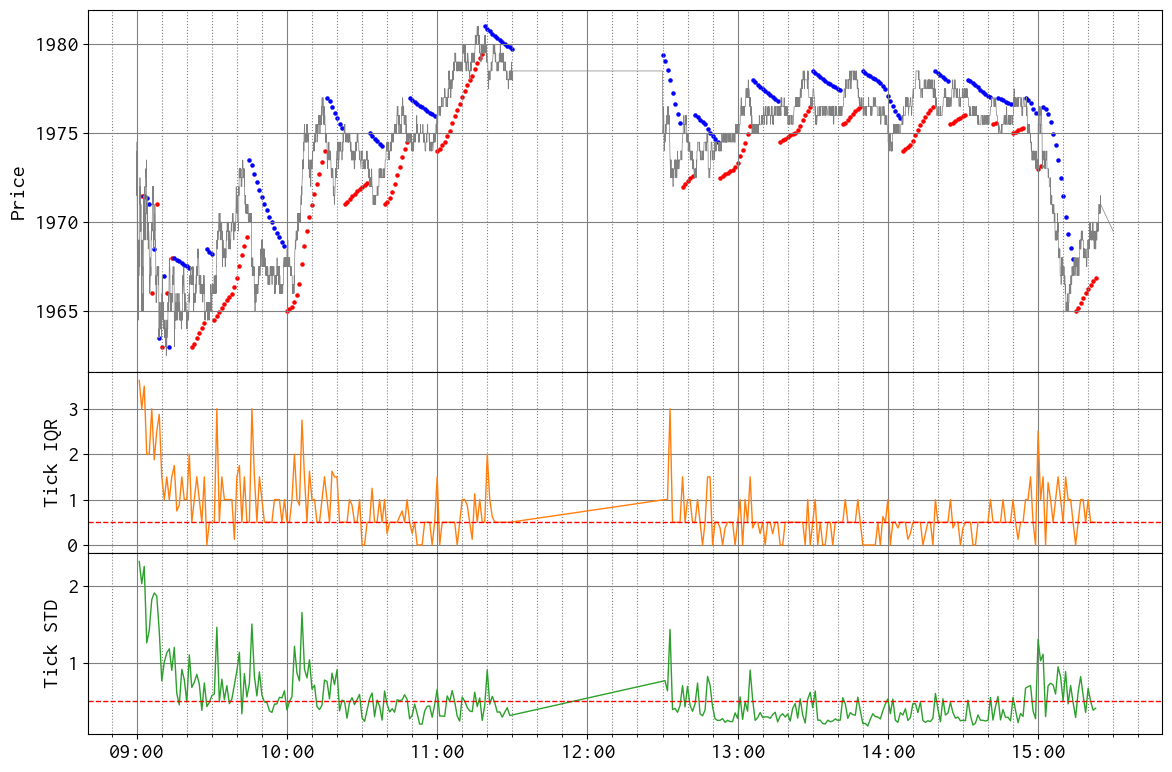

In [50]:
FONT_PATH = 'fonts/RictyDiminished-Regular.ttf'
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 3
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    #ax[i].grid(which='both')
    ax[i].grid(visible=True, which='major', color='gray', linestyle='-')
    ax[i].grid(visible=True, which='minor', color='gray', linestyle='dotted')


# ティックデータ
ax[0].plot(
    df_tick,
    linewidth=0.5,
    color='gray',
)
# PSAR
ser_bull = df_ohlc[df_ohlc['TREND'] == 1]['PSAR']
ax[0].scatter(
    ser_bull.index,
    ser_bull,
    s=5,
    c='red',
)
ser_bear = df_ohlc[df_ohlc['TREND'] == -1]['PSAR']
ax[0].scatter(
    ser_bear.index,
    ser_bear,
    s=5,
    c='blue',
)

ax[0].xaxis.set_major_formatter(
    mdates.DateFormatter('%H:%M')
)
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator([10, 20, 30, 40, 50]))
ax[0].set_ylabel('Price')


ax[1].plot(
    df_sigma['iqr'],
    linewidth=1,
    color='C1',
)
ax[1].axhline(
    y=0.5,
    color='red',
    linewidth=1,
    linestyle='dashed',
)
ax[1].set_ylabel('Tick IQR')


ax[2].plot(
    df_sigma['stdev'],
    linewidth=1,
    color='C2',
)
ax[2].axhline(
    y=0.5,
    color='red',
    linewidth=1,
    linestyle='dashed',
)
ax[2].set_ylabel('Tick STD')


plt.tight_layout()
plt.savefig('study_008.png')
plt.show()